In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! nvidia-smi

Fri Aug 13 12:09:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    39W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam, Adadelta
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
# Set some parameters
im_width = 512
im_height = 512
border = 5

In [ ]:
ids = next(os.walk("/content/drive/MyDrive/t4/50k") )[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  5445


In [ ]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

#### Load the images and masks into arrays

In [ ]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("/content/drive/MyDrive/t4/50k/"+id_, color_mode = "grayscale")
    x_img = img_to_array(img)
    x_img = resize(x_img, (512, 512, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("/content/drive/MyDrive/t4/100k/"+id_, color_mode = "grayscale"))
    mask = resize(mask, (512, 512, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

#### Below code can be used to visualize the images and corresponding masks

Text(0.5, 1.0, 'Salt')

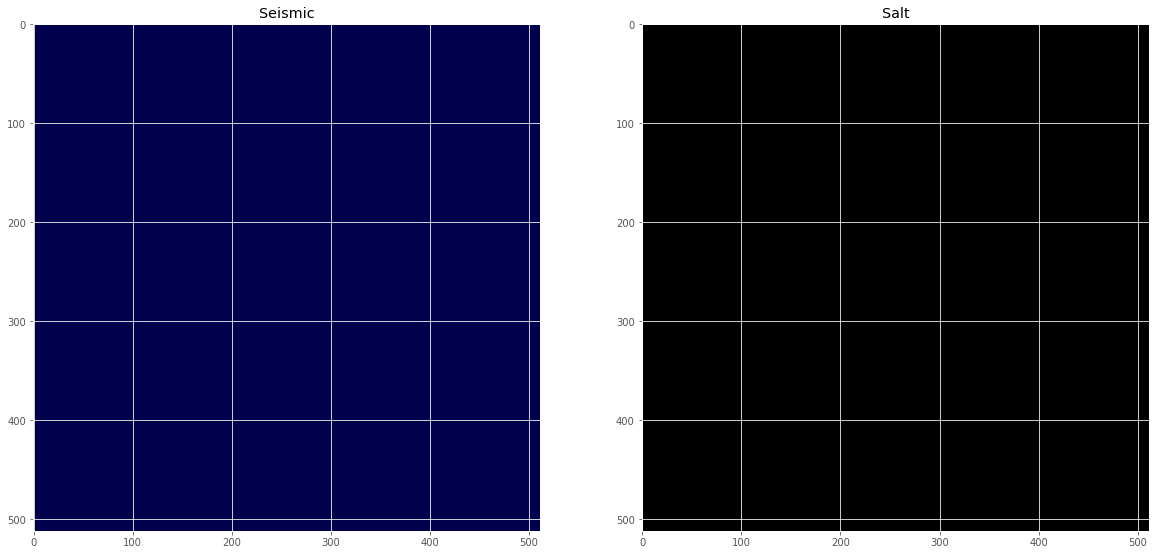

In [ ]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # generalized image indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask:
    # draw a boundary(contour) in the original image to seperate the generalized and ungeneralized builiding
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('50k')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('100k')

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [ ]:
def get_unet(input_img, n_filters = 16, dropout = 0.05, batchnorm = True):
    """Function to define the UNET Model"""
    # encoder path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 32, kernel_size = 3, batchnorm = batchnorm)
    
    # decoder path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 512, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 512, 512, 16) 0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

In [ ]:
data_gen_args = dict(rotation_range=0.2,
                     horizontal_flip=True,
                     vertical_flip=True)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 2018
bs = 16

image_generator = image_datagen.flow(X_train, seed=seed, batch_size=bs, shuffle=True)
mask_generator = mask_datagen.flow(y_train, seed=seed, batch_size=bs, shuffle=True)

# Just zip the two generators to get a generator that provides augmented images and masks at the same time
train_generator = zip(image_generator, mask_generator)

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('/content/drive/MyDrive/UNET-TGS-master - 50_100/5lv 16bs moreimages.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = model.fit(X_train, y_train, batch_size=bs, epochs=100, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Epoch 1/100
307/307 [==============================] - 92s 169ms/step - loss: 0.2542 - accuracy: 0.9459 - val_loss: 0.1222 - val_accuracy: 0.9596

Epoch 00001: val_loss improved from inf to 0.12216, saving model to /content/drive/MyDrive/UNET-TGS-master - 50_100/5lv 16bs moreimages.h5
Epoch 2/100
307/307 [==============================] - 49s 159ms/step - loss: 0.1220 - accuracy: 0.9595 - val_loss: 0.1087 - val_accuracy: 0.9593

Epoch 00002: val_loss improved from 0.12216 to 0.10869, saving model to /content/drive/MyDrive/UNET-TGS-master - 50_100/5lv 16bs moreimages.h5
Epoch 3/100
307/307 [==============================] - 49s 159ms/step - loss: 0.1144 - accuracy: 0.9593 - val_loss: 0.1052 - val_accuracy: 0.9607

Epoch 00003: val_loss improved from 0.10869 to 0.10524, saving model to /content/drive/MyDrive/UNET-TGS-master - 50_100/5lv 16bs moreimages.h5
Epoch 4/100
307/307 [==============================] - 49s 159ms/step - loss: 0.1136 - accuracy: 0.9588 - val_loss: 0.1069 - val_accur

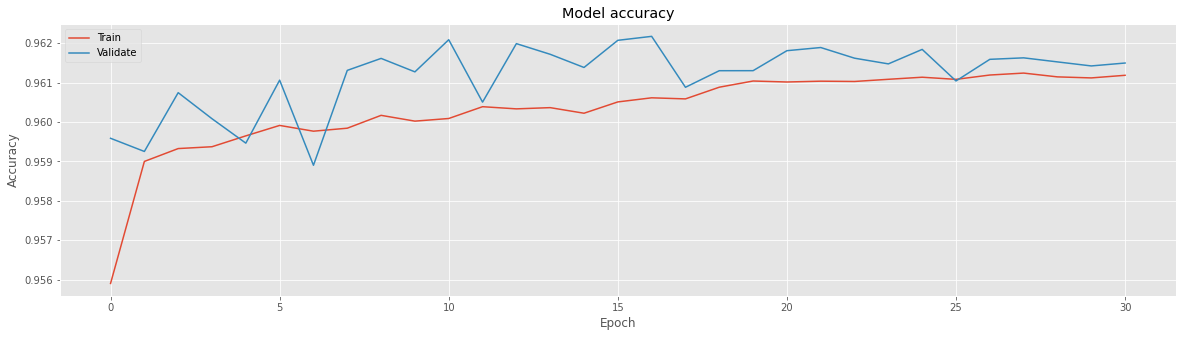

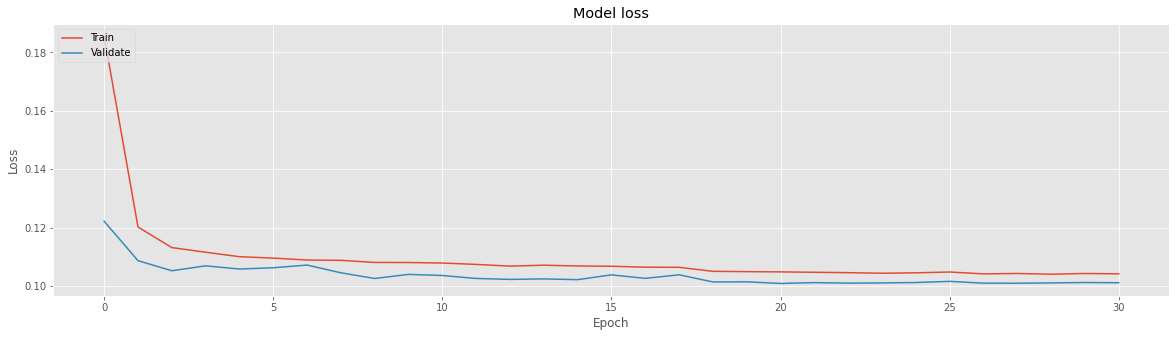

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

### Inference

In [ ]:
idss = next(os.walk("/content/drive/MyDrive/t4/50t"))[2] # list of names all images in the given path
idss.sort(key=lambda x:int(x.split('.')[0])) #arrange in order
print("No. of images = ", len(idss))

No. of images =  297


In [ ]:
pX = np.zeros((len(idss), im_height, im_width, 1), dtype=np.float32)
py = np.zeros((len(idss), im_height, im_width, 1), dtype=np.float32)

In [ ]:
for n, id_ in tqdm_notebook(enumerate(idss), total=len(idss)):
    # Load images
    imgs = load_img("/content/drive/MyDrive/t4/50t/"+id_, color_mode = "grayscale")
    px_img = img_to_array(imgs)
    px_img = resize(px_img, (512, 512, 1), mode = 'constant', preserve_range = True)
    # Load masks
    pmask = img_to_array(load_img("/content/drive/MyDrive/t4/100t/"+id_, color_mode = "grayscale"))
    pmask = resize(pmask, (512, 512, 1), mode = 'constant', preserve_range = True)
    # Save images
    pX[n] = px_img/255.0
    py[n] = pmask/255.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [ ]:
# load the best model
model.load_weights('/content/drive/MyDrive/UNET-TGS-master - 50_100/5lv 16bs moreimages.h5')

In [ ]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(pX, py, verbose=1, batch_size = 16)

19/19 [==============================] - 1s 49ms/step - loss: 0.1056 - accuracy: 0.9591


[0.10561489313840866, 0.9591240286827087]

In [ ]:
preds_val = model.predict(pX, verbose=1, batch_size = 16)

19/19 [==============================] - 1s 54ms/step


In [ ]:
preds_val_t = (preds_val > 0.5).astype(np.uint8)

### Predictions on test set and save image

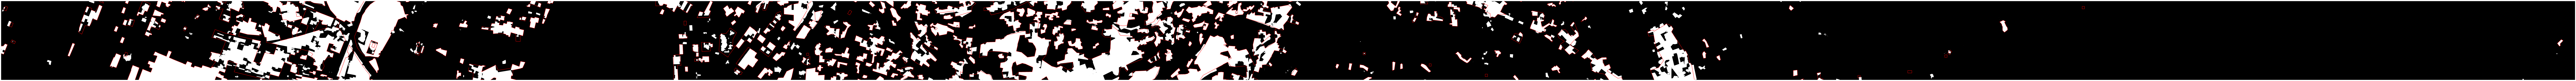

In [ ]:
fig, axes = plt.subplots(3,99, figsize=(297,9))
for i,ax in enumerate(axes.flat):
  y = py
  has_mask = y[i].max() > 0
  if has_mask:
        ax.contour(y[i].squeeze(), colors='red', levels=[0.5])
  ax.axis('off')
  plt.subplots_adjust(wspace=-0.8, hspace=0)
  ax.imshow(preds_val_t[i].squeeze(), vmin=0, vmax=1, cmap='gray')

# plt.savefig('/content/drive/MyDrive/t4/predict50.tif', dpi=200, bbox_inches='tight', pad_inches=0)